# Power Analysis

In [73]:
import cPickle
import datetime
import glob
import gzip
import os
import random
import re
import shutil
import subprocess
import time
import uuid

import cdpybio as cpb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import pybedtools as pbt
import scipy
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
import vcf as pyvcf

import cardipspy as cpy
import ciepy

%matplotlib inline
%load_ext rpy2.ipython

dy_name = 'power_analysis'

import socket
if socket.gethostname() == 'fl-hn1' or socket.gethostname() == 'fl-hn2':
    dy = os.path.join(ciepy.root, 'sandbox', 'tmp', dy_name)
    cpy.makedir(dy)
    pbt.set_tempdir(dy)
    
outdir = os.path.join(ciepy.root, 'output', dy_name)
cpy.makedir(outdir)

private_outdir = os.path.join(ciepy.root, 'private_output', dy_name)
cpy.makedir(private_outdir)

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [2]:
exp = pd.read_table(os.path.join(ciepy.root, 'output', 'eqtl_input', 
                                 'tpm_log_filtered_phe_std_norm_peer_resid.tsv'), index_col=0)

rna_meta = pd.read_table(os.path.join(ciepy.root, 'output', 'input_data', 'rnaseq_metadata.tsv'),
                         index_col=0)

fn = os.path.join(ciepy.root, 'output/eqtl_processing/eqtls01/qvalues.tsv')
qvalues = pd.read_table(fn, index_col=0)

In [3]:
def power_plots(tdf):
    for i in np.arange(40, 110, 10):
        df = pd.crosstab(tdf['power_{}_bin'.format(i)], tdf['sig_{}'.format(i)])
        df['percent'] = df[True] / df.sum(axis=1)
        plt.figure()
        df.percent.plot()
        plt.title(i)
        plt.ylabel('Observed power')
        plt.xlabel('Estimated power');

I want to look at power a few different ways. 
I want to take my unrelateds and subsample them like GTEx does to see how many
eGenes I gain as I increase my sample size. I should probably run the full eQTL
analysis (with permutations) for the full unrelated set as well.

I'm also going to make an estimate of
my power to detect GTEx and Geuvadis eQTLs and compare them to my actual ability
to detect the eQTLs. For each Geuvadis/GTEx eQTL, I'll calculate an $R^2$. Since 
Geuvadis provides $r$ for each eQTL, I can just square $r$. GTEx provides $\beta$, 
so I can calculate $R^2$ for a given association as 

\begin{align}
R^2 = \left(\beta \frac{s_v}{s_g}\right)^2,
\end{align}

where $s_v$ is the standard deviation of my genotypes at the position and $s_g$ is the
standard deviation of the gene's expression in the GTEx data. I can then calculate

\begin{align}
f^2 = \frac{R^2}{1 - R^2},
\end{align}

which I can use in a power test for linear regression.

The power calculation is kind of slow when done so many times so this notebook takes a while to run
if you need to redo the power calculations.

### Derivation of $R^2$ estimate

For simple linear regression, we know

\begin{align}
\hat{\beta} = \frac{\textrm{cov}(x,y)}{\sigma_x^2},
\end{align}

and

\begin{align}
r = \frac{\textrm{cov}(x,y)}{\sigma_x \sigma_y}.
\end{align}

Thus

\begin{align}
R^2 &= r^2, \\
&= \left(\frac{\hat{\beta}\sigma_x^2}{\sigma_x \sigma_y}\right)^2, \\
&= \left(\hat{\beta}\frac{\sigma_x}{\sigma_y}\right)^2.
\end{align}

## Subsets

In [157]:
[rna_meta.in_eqtl.sum()], [qvalues.perm_sig.sum()]

([215], [5816])

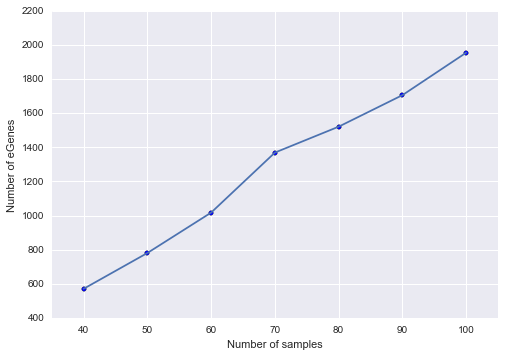

In [159]:
cols = [40, 50, 60, 70, 80, 90, 100]
pvals = {}
for i in cols:
    fn = os.path.join(ciepy.root, 'output', 'eqtl_processing', 
                      'unrelated_eqtls_{}'.format(i), 'min_pvalues_corrected.tsv')
    pvals[i] = pd.read_table(fn, index_col=0).min_pval_bf
pvals = pd.DataFrame(pvals)

(pvals < 0.05).sum().plot()
plt.scatter(pvals.columns, (pvals < 0.05).sum().values)
#plt.scatter([rna_meta.in_eqtl.sum()], [qvalues.perm_sig.sum()])
plt.xlim(35, 105)
plt.xlabel('Number of samples')
plt.ylabel('Number of eGenes');

## pwr

TODO: Below, I calculate the genotype stdev by pulling the genotypes out of the VCF files.
However, I could more easily just read the EMMAX results files and use the `genocnt` column.
This would save time for this step and the power step since I could avoid calculating power
for some of the GTEx variants I don't have. I also need to make sure to calculate genotype stdev
for each set of subjects (40, 50, 60, etc.).

In [5]:
def pwr_df(df, u, v):
    """
    Execute pwr.f2.test. The dataframe df must have a column f2.
    """
    import rpy2.robjects as ro
    ro.r('suppressPackageStartupMessages(library(pwr))')
    ro.globalenv['df'] = df
    ro.globalenv['u'] = u
    ro.globalenv['v'] = v
    ro.r('p = rep(1, dim(df)[2])')
    ro.r('for(i in 1:dim(df)[1]) {'
         'p[i] = pwr.f2.test(u=u, v=v, f2=df[i, "f2"], '
         'sig.level=0.001, power=NULL)["power"]}')
    p = ro.globalenv['p']
    power = [x[0] for x in p]
    return power

In [6]:
def pwr(f2, u, v):
    """
    Execute pwr.f2.test.
    """
    import rpy2.robjects as ro
    ro.r('suppressPackageStartupMessages(library(pwr))')
    ro.globalenv['f2'] = f2
    ro.globalenv['u'] = u
    ro.globalenv['v'] = v
    ro.r('p = pwr.f2.test(u=u, v=v, f2=f2, sig.level=0.001, power=NULL)["power"]')
    p = list(ro.globalenv['p'])[0][0]
    return p

Here's an example of using `pwr.f2.test`.

In [7]:
%%R

suppressPackageStartupMessages(library(pwr))
pwr.f2.test(u=2, v=117, f2=0.060995, sig.level=0.001, power=NULL)


     Multiple regression power calculation 

              u = 2
              v = 117
             f2 = 0.060995
      sig.level = 0.001
          power = 0.1766086



### Genotype stdev

In [8]:
def calc_stdev(x):
    hr, het, ha = [int(x) for x in x.split('/')]
    out = np.std([0] * hr + [1] * het + [2] * ha)
    return out

In [9]:
stdev = {}
for i in np.arange(40, 110, 10):
    k = 'geno_stdev_{}'.format(i)
    out = os.path.join(outdir, '{}.tsv'.format(k))
    if not os.path.exists(out):
        fn = os.path.join(ciepy.root, 'output', 'eqtl_processing', 
                          'unrelated_eqtls_{}'.format(i), 'top_snv_results_sorted.tsv.gz')
        df = pd.read_table(fn, header=None, low_memory=False)
        se = df[7].apply(lambda x: calc_stdev(x))
        se.index = 'chr' + df[0].astype(str) + ':' + df[1].astype(str)
        stdev[k] = se
        stdev[k].to_csv(out, sep='\t')
    else:
        stdev[k] = pd.read_table(out, index_col=0, header=None, squeeze=True)

In [11]:
fn = os.path.join(outdir, 'genotype_stdevs.tsv')
if not os.path.exists(fn):
    ind = []
    for v in stdev.values():
        ind += list(v.index)
    ind = set(ind)
    for k in stdev:
        stdev[k] = stdev[k][ind]
    geno_stdev = pd.DataFrame(stdev)
    geno_stdev.to_csv(fn, sep='\t')
else:
    geno_stdev = pd.read_table(fn, index_col=0)

### Geuvadis

### GTEx

The power calculations are pretty slow if we calculate for each individual
association. To speed this up, we'll precalculate the power values for 
different $f2$ values and figure out for which values the power is one.

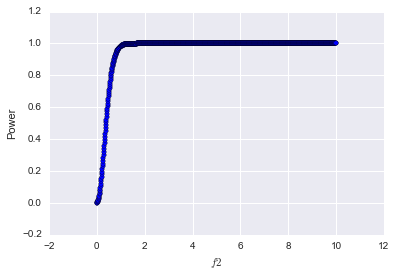

In [15]:
vals = []
for i in np.arange(0, 10, 0.01):
    vals.append(pwr(i, 2, 37))
plt.scatter(np.arange(0, 10, 0.01), vals)
plt.xlabel('$f2$')
plt.ylabel('Power');

We can see that even for 40 samples the power goes to one near $f^2 = 1$. This
will happen even faster for more samples.

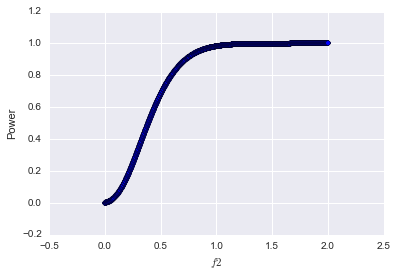

In [16]:
vals = []
for i in np.arange(0, 2, 0.001):
    vals.append(pwr(i, 2, 37))
plt.scatter(np.arange(0, 2, 0.001), vals)
plt.xlabel('$f2$')
plt.ylabel('Power');

I'll go in increments of $0.001$ until I reach power of one.

In [17]:
def precalculate_power(u, v):
    i = 0
    cur_power = 0
    ind = []
    vals = []
    while cur_power < 1.:
        cur_power = pwr(i, u, v)
        vals.append(cur_power)
        i += 0.001
    pdf = pd.DataFrame(vals, index=np.arange(0, i, 0.001), columns=['power'])
    return pdf

In [18]:
# Precalculate power values.
power = {}
for i in np.arange(40, 110, 10):
    power[i] = precalculate_power(2, i - 3)
    power[i].columns = ['power_{}'.format(i)]

In [20]:
def get_gene_res(gene, dy, gtex_ind):
    fn = os.path.join(dy, gene, '{}.tsv'.format(gene))
    res = ciepy.read_emmax_output(fn)
    res.index = 'chr' + res.CHROM.astype(str) + ':' + res.BEG.astype(str) + ':' + gene
    if type(gtex_ind) == str:
        ind = [gtex_ind]
    else:
        ind = gtex_ind.values
    ind = set(res.index) & set(ind)
    res = res.ix[ind]
    return res.PVALUE < 0.001

The code below takes a while to run. The longest part is reading
through all of my results for the individual genes for each eQTL 
analysis. This could probably be sped up by running on an IPython
cluster.

In [ ]:
fns = glob.glob('/publicdata/gtex_v6/*.snpgenes')
out_fns = glob.glob(os.path.join(outdir, 'gtex_*_power.tsv'))
if len(out_fns) != fns:
    gtex_results = {}
    gtex_sig = []
    for fn in fns:
        k = os.path.split(fn)[1][:-18]
        t = pd.read_table(fn, index_col=0, low_memory=False)
        ref = [x.split('_')[2] for x in t.index]
        alt = [x.split('_')[2] for x in t.index]
        t['ref_length'] = [len(x) for x in ref]
        t['alt_length'] = [len(x) for x in alt]
        t = t[t.ref_length == 1]
        t = t[t.alt_length == 1]
        t['chr_pos'] = ('chr' + t.snp_chrom.astype(str) + ':' + t.snp_pos.astype(str))
        t = t.merge(geno_stdev, left_on='chr_pos', right_index=True)
        for i in np.arange(40, 110, 10):
            t['R2_{}'.format(i)] = (t.beta * t['geno_stdev_{}'.format(i)]) ** 2
            # We'll round the f2 values so I can use my precalculated power estimates.
            t['f2_{}'.format(i)] = np.round(t['R2_{}'.format(i)] / (1. - t['R2_{}'.format(i)]), 3)
            # f2 must be positive. Negative is probably a numeric problem.
            t = t[t['f2_{}'.format(i)] > 0]
            cpower = power[i].ix[set(t['f2_{}'.format(i)])].dropna()
            t = t.merge(cpower, left_on='f2_{}'.format(i), right_index=True, how='outer')
            t.ix[t['power_{}'.format(i)].isnull(), 'power_{}'.format(i)] = 1
        tt = 'chr' + t.snp_chrom.astype(str) + ':' + t.snp_pos.astype(str) + ':' + t.gene
        tt.index = t.gene
        gtex_sig.append(tt)
        gtex_results[k] = t
    gtex_sig = pd.concat(gtex_sig).drop_duplicates()
    gtex_sig = gtex_sig.ix[set(gtex_sig.index) & set(qvalues.index)]
    
    my_gtex_results = pd.DataFrame(index=gtex_sig.values)

#     for i in np.arange(40, 110, 10):
#         col = 'sig_{}'.format(i)
#         my_gtex_results[col] = np.nan
#         dy = os.path.join(ciepy.root, 'private_output', 'run_eqtl_analysis',
#                           'unrelated_eqtls_{}'.format(i), 'gene_results')
#         for gene in set(gtex_sig.index):
#             fn = os.path.join(dy, gene, '{}.tsv'.format(gene))
#             res = ciepy.read_emmax_output(fn)
#             res.index = 'chr' + res.CHROM.astype(str) + ':' + res.BEG.astype(str) + ':' + gene
#             t = gtex_sig.ix[gene]
#             if type(t) == str:
#                 ind = [t]
#             else:
#                 ind = t.values
#             ind = set(res.index) & set(ind)
#             res = res.ix[ind]
#             my_gtex_results.ix[ind, col] = (res.PVALUE < 0.001).values
    from ipyparallel import Client
    parallel_client = Client(profile='parallel')
    dview = parallel_client[:]
    print('Cluster has {} engines.'.format(len(parallel_client.ids)))
    

    with dview.sync_imports():
        import numpy
        import ciepy
        import os
        import vcf

    %px np = numpy

    dview.push(dict(get_gene_res=get_gene_res))
    
    todo = []
    for g in set(gtex_sig.index):
        todo.append([g, gtex_sig[g]])

    my_gtex_results = {}
    for i in np.arange(40, 110, 10):
        dy = os.path.join(ciepy.root, 'private_output', 'run_eqtl_analysis',
                          'unrelated_eqtls_{}'.format(i), 'gene_results')
        dview.push(dict(dy=dy))
        t = dview.map_sync(lambda x: get_gene_res(x[0], dy, x[1]), todo)
        tt = pd.concat(t)
        my_gtex_results['sig_{}'.format(i)] = tt
    my_gtex_results = pd.DataFrame(my_gtex_results)
        
    for k in gtex_results.keys():
        t = gtex_results[k]
        t['chr_pos_gene'] = t.chr_pos + ':' + t.gene
        t = t.merge(my_gtex_results, left_on='chr_pos_gene', right_index=True)
        for i in np.arange(40, 110, 10):
            t['power_{}_bin'.format(i)] = pd.cut(t['power_{}'.format(i)], np.arange(0, 1.01, 0.01)).values
        gtex_results[k] = t
        out = os.path.join(outdir, 'gtex_{}_power.tsv'.format(k))
        t.to_csv(out, sep='\t')

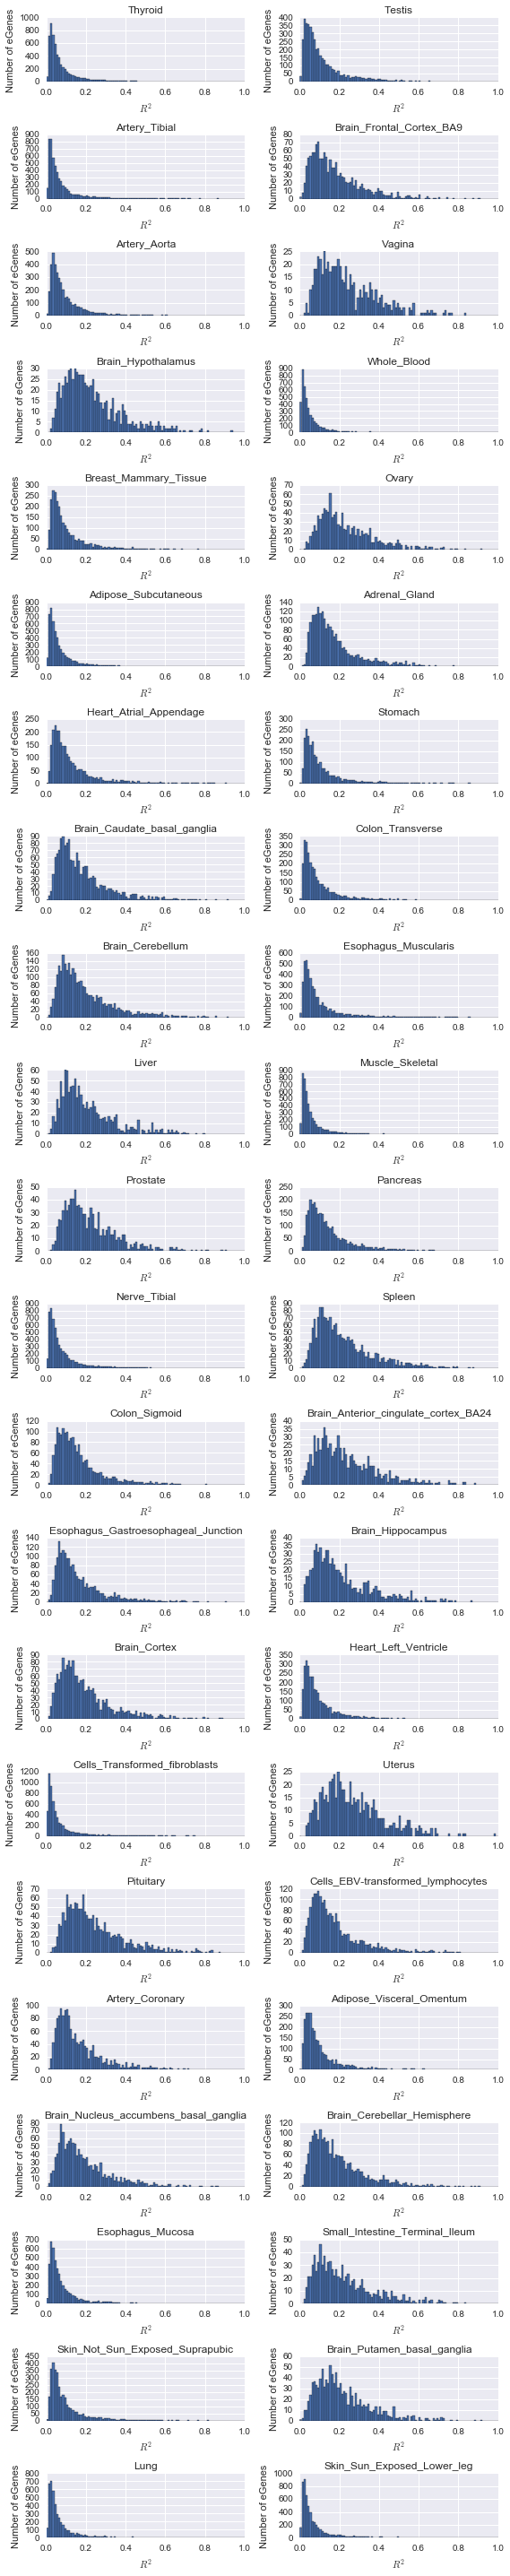

In [37]:
fig,axs = plt.subplots(len(gtex_results) / 2, 2, figsize=(8, 40))
for i,k in enumerate(gtex_results.keys()):
    ax = axs[i / 2, i % 2]
    t = gtex_results[k]
    t = t.sort_values(by='p_value')
    t = t.drop_duplicates('gene')
    t.R2_100.hist(bins=np.arange(0, 1.01, 0.01), ax=ax)
    ax.set_title(k);
    ax.set_ylabel('Number of eGenes')
    ax.set_xlabel('$R^2$');
plt.tight_layout()

In [ ]:
def power_plots(tdf):
    for i in np.arange(40, 110, 10):
        df = pd.crosstab(tdf['power_{}_bin'.format(i)], tdf['sig_{}'.format(i)])
        df['percent'] = df[True] / df.sum(axis=1)
        plt.figure()
        df.percent.plot()
        plt.title(i)
        plt.ylabel('Observed power')
        plt.xlabel('Estimated power');

In [95]:
import statsmodels.api as sm

In [104]:
t = gtex_results['Thyroid']
i = 40

In [105]:
df = pd.crosstab(t['power_{}_bin'.format(i)], t['sig_{}'.format(i)])
df['percent'] = df[True] / df.sum(axis=1)

In [140]:
def power_plots(tdf):
    with sns.plotting_context('notebook', font_scale=1.5):
        plt.figure(figsize=(8, 8))
        for n,i in enumerate(np.arange(40, 110, 10)):
            df = pd.crosstab(tdf['power_{}_bin'.format(i)], tdf['sig_{}'.format(i)])
            df['percent'] = df[True] / df.sum(axis=1)
            xs = np.arange(0, 1, 0.01)
            smoothed = pd.DataFrame(sm.nonparametric.lowess(df.percent, xs), 
                                    columns=['x', i])
            smoothed.index = smoothed['x']

            smoothed[i].plot(color=cpb.analysis.tableau20[2 * n])
            plt.title(i)
            plt.ylabel('Observed power')
            plt.xlabel('Estimated power')
        plt.title('')
        plt.legend(loc='upper left');

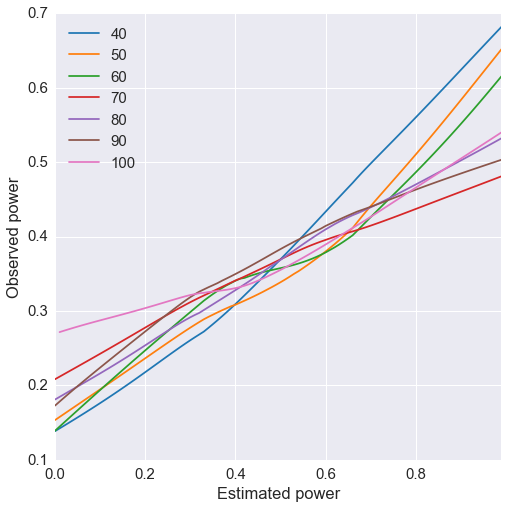

In [141]:
power_plots(gtex_results['Liver'])

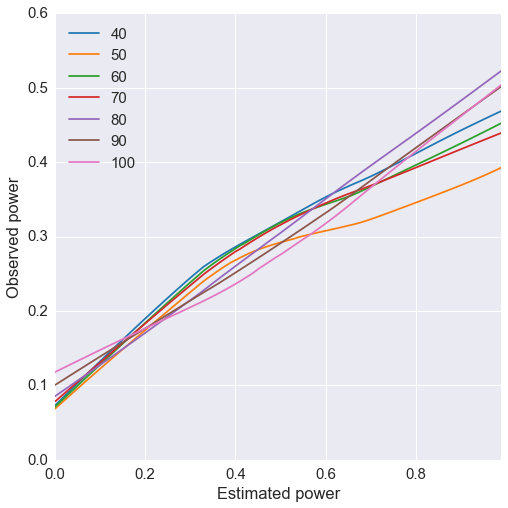

In [142]:
power_plots(gtex_results['Thyroid'])

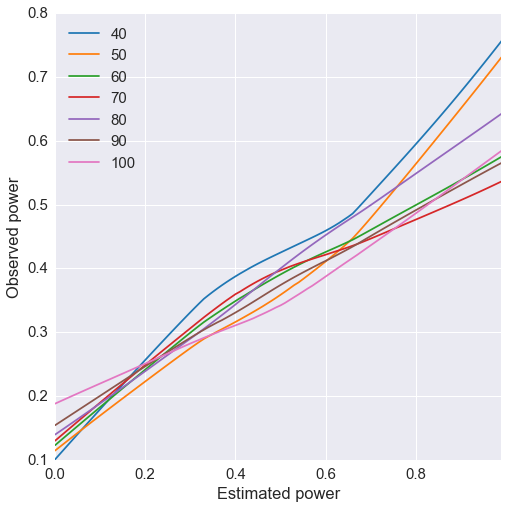

In [143]:
power_plots(gtex_results['Lung'])

In [161]:
t = gtex_results['Lung']

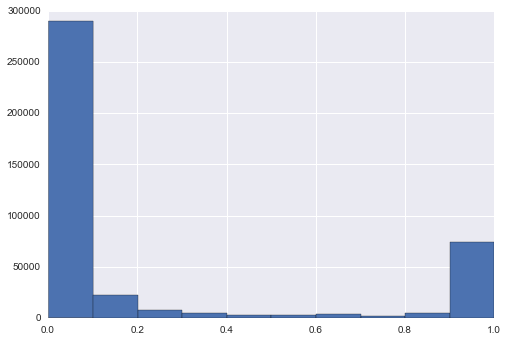

In [153]:
t.power_40.hist()

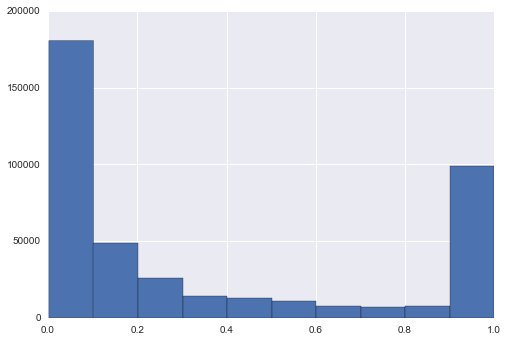

In [165]:
t.power_100.hist()

In [169]:
prop_p100 = []
for k in gtex_results.keys():
    t = gtex_results[k]
    t = t[t.power_100 == 1]
    prop_p100.append(t.sig_100.sum() / float(t.shape[0]))
prop_p100 = pd.Series(prop_p100, index=gtex_results.keys())
prop_p100.sort_values(inplace=True)

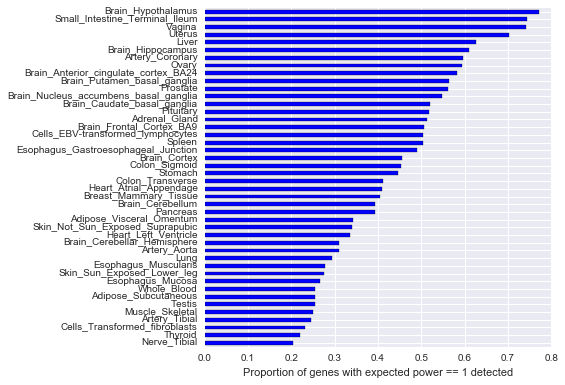

In [176]:
prop_p100.plot(kind='barh')
plt.xlabel('Proportion of genes with expected power == 1 detected')
plt.tight_layout()

This is still affected by sample size since tissues with small 
sample size have few eQTLs with large effect sizes.